In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
direct = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        direct = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv


Gender: 0 - male; 1 - female

Ethnicity: 0 - white; 1 - afro-american; 2 - asian; 3 - indian (brown); 4 - unkown for me :D

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from IPython.display import Image
from skimage.transform import resize
from skimage.io import imread, imshow

In [56]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [4]:
df = pd.read_csv(direct)

In [5]:
df.head()


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [6]:
df.shape

(23705, 5)

## EDA for the data

This part is necessary for every project. You should know your data and the way of dependency of its features.  

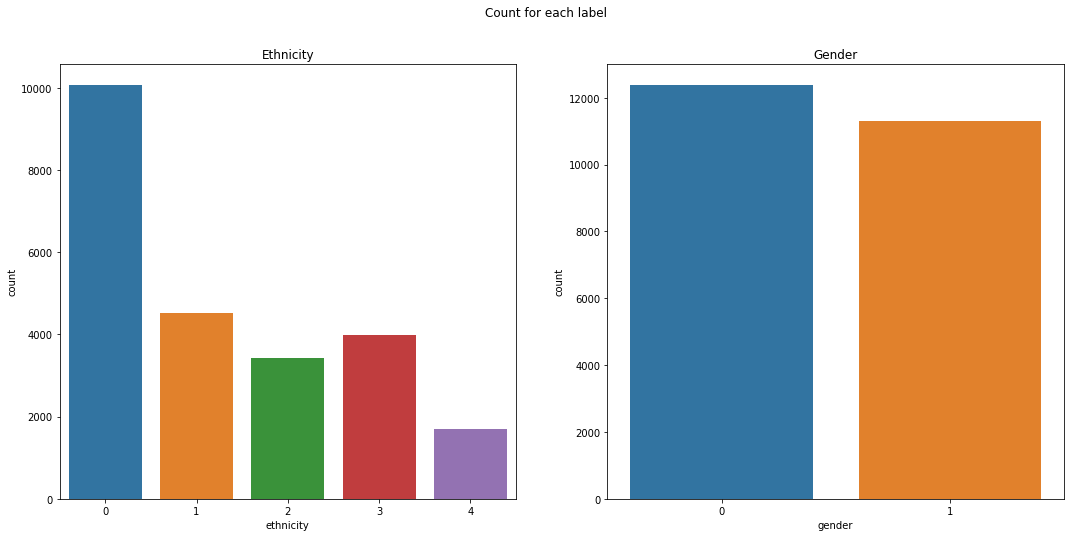

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))
fig.suptitle("Count for each label")

sns.countplot(ax = axes[0], x = df.ethnicity)
axes[0].set_title("Ethnicity")

sns.countplot(ax = axes[1], x = df.gender)
axes[1].set_title("Gender")

plt.show()

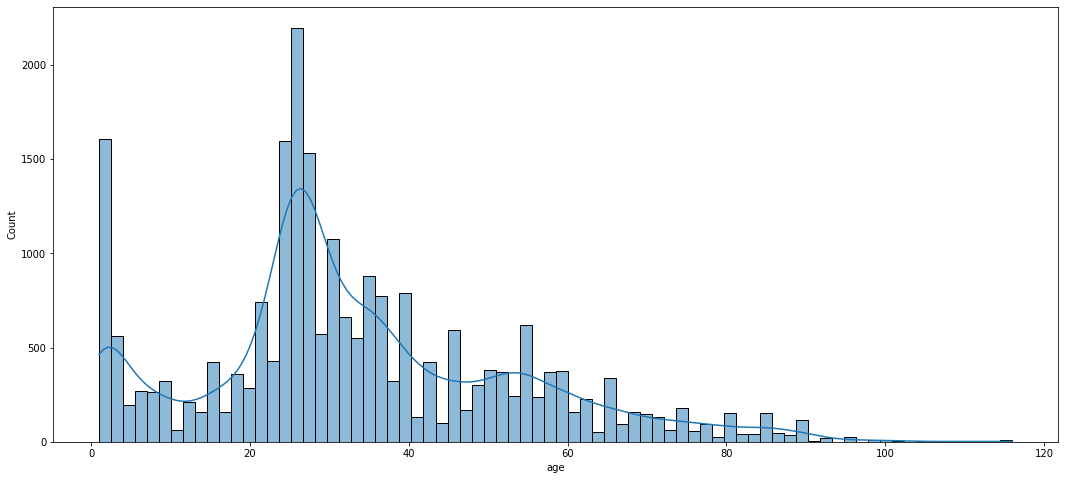

In [8]:
plt.figure(figsize=(18,8))
sns.histplot(df.age, kde=True)
plt.show()

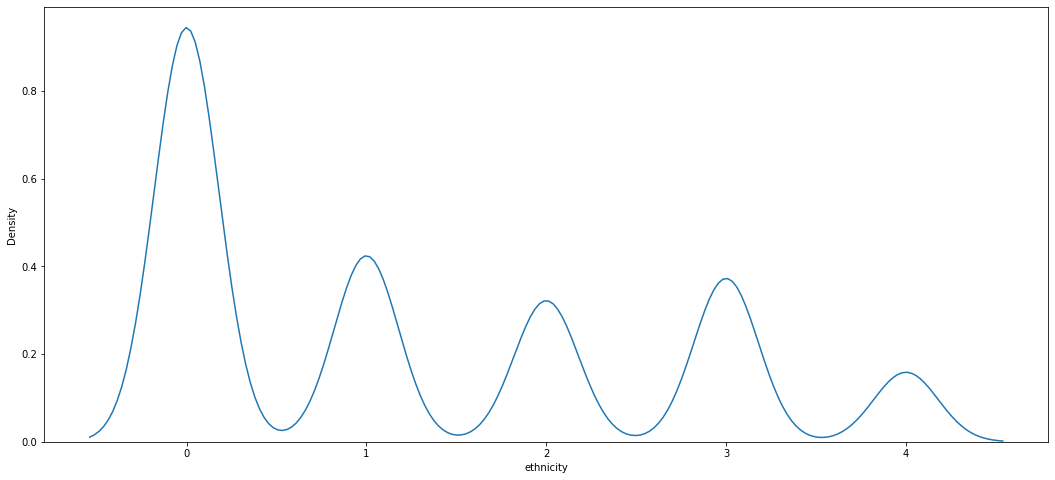

In [9]:
plt.figure(figsize=(18,8))
sns.kdeplot(x=df.ethnicity)
plt.show()

In [10]:
df.corr()

,age,ethnicity,gender
age,1.000000,-0.217844,-0.126030
ethnicity,-0.217844,1.000000,0.027364
gender,-0.126030,0.027364,1.000000


We saw for the Ethnicity we have kinda unbalanced data but for gender prediction will not be a problem. 
Both of those problems are classification ones but for age prediction we have rregression.
First of all I saw really old people here but are they really that old or dataset mistake?
Should i take them for training ?

In [11]:
df.age.describe()

count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [12]:
def pixel_reshape(column):
    column = np.array([x for x in column.str.split()], dtype ="float32")
    column = np.reshape(column, (-1,48,48,1))
    return np.array(column)

In [13]:
old_people = df[df.age > 95]

In [14]:
oldImgs = pixel_reshape(old_people.pixels)

In [15]:
oldImgs.shape

(58, 48, 48, 1)

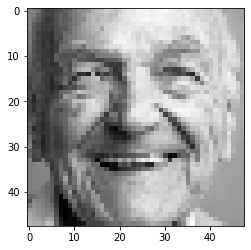

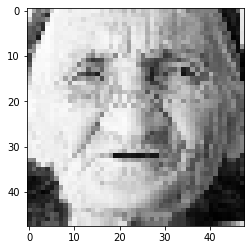

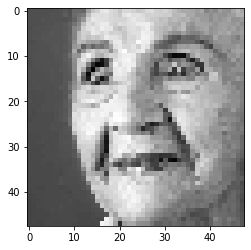

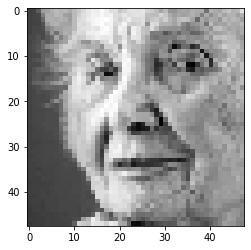

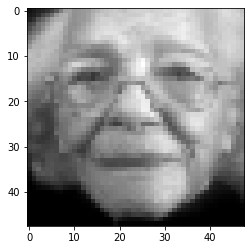

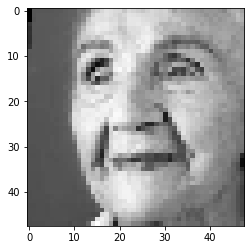

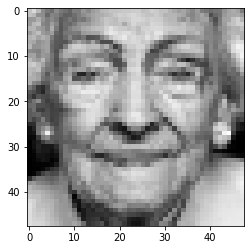

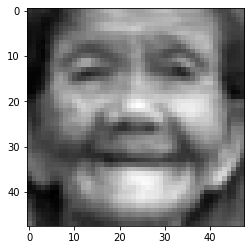

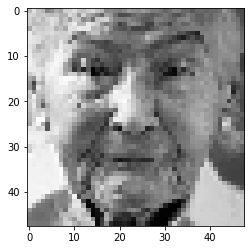

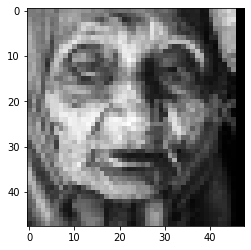

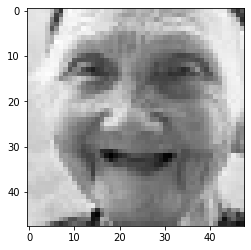

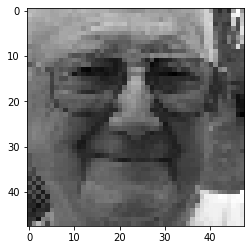

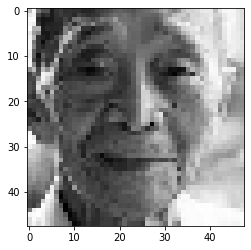

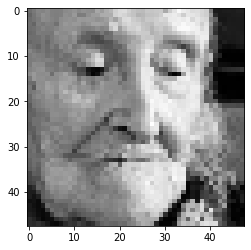

In [16]:
for i in range(1, 15):
    plt.imshow(oldImgs[i], cmap = "gray")
    plt.show()  

So for now we can see that they are actually old people but we have very few of them. We can se duplicated as well. Ether out regression model is going to be good on predicting the age are we are going to need data augmentation for those years.... 

#### Scale Data

### Age classification
train, val, test split the data based on Gender

In [17]:
TRAIN_PCT = 0.8
VAL_PCT = 0.1
TEST_PCT = 0.1


In [18]:
def get_stratify_split_by(df, category):
    train_data = pd.DataFrame()
    val_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for (label, group_img) in df.groupby(category):
        group_img = group_img.sample(len(group_img), random_state=24)

        train_data_end_index = int(len(group_img) * TRAIN_PCT)
        val_data_end_index = train_data_end_index + int(len(group_img) * VAL_PCT)


        train_data_in_group = group_img[:train_data_end_index]
        val_data_in_group = group_img[train_data_end_index:val_data_end_index]
        test_data_in_group = group_img[val_data_end_index :]

        print(len(train_data_in_group), len(val_data_in_group), len(test_data_in_group))

        train_data = train_data.append(train_data_in_group)
        val_data = val_data.append(val_data_in_group)
        test_data = test_data.append(test_data_in_group)
    return train_data, val_data, test_data

In [19]:
train_data, val_data, test_data = get_stratify_split_by(df, "gender")

9912 1239 1240
9051 1131 1132


In [20]:
train_data.ethnicity.value_counts(), val_data.ethnicity.value_counts(), test_data.ethnicity.value_counts()

(0    8092
 1    3629
 3    3122
 2    2766
 4    1354
 Name: ethnicity, dtype: int64,
 0    987
 1    446
 3    421
 2    345
 4    171
 Name: ethnicity, dtype: int64,
 0    999
 1    451
 3    432
 2    323
 4    167
 Name: ethnicity, dtype: int64)

In [21]:
train_data.shape, val_data.shape, test_data.shape

((18963, 5), (2370, 5), (2372, 5))

In [22]:
X_train = (pixel_reshape(train_data.pixels)) / 255
X_val = (pixel_reshape(val_data.pixels)) / 255
X_test = (pixel_reshape(test_data.pixels)) / 255

In [24]:
model_one = Sequential([
    Conv2D(16, padding="same", kernel_size=(2, 2), input_shape=((48,48,1))),
    MaxPool2D((2, 2)),
    Conv2D(32, kernel_size=(3, 3), padding="same"),
    MaxPool2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), padding="valid"),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

In [25]:
model_one.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [26]:
model_one.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [27]:
model_one_hist = model_one.fit(X_train, train_data.gender, batch_size=64, epochs=8, validation_data=(X_val, val_data.gender))

Epoch 1/8
297/297 [==============================] - 18s 59ms/step - loss: 0.5051 - accuracy: 0.7409 - val_loss: 0.3367 - val_accuracy: 0.8481
Epoch 2/8
297/297 [==============================] - 18s 59ms/step - loss: 0.3154 - accuracy: 0.8598 - val_loss: 0.3161 - val_accuracy: 0.8633
Epoch 3/8
297/297 [==============================] - 17s 58ms/step - loss: 0.2748 - accuracy: 0.8813 - val_loss: 0.3006 - val_accuracy: 0.8705
Epoch 4/8
297/297 [==============================] - 18s 59ms/step - loss: 0.2466 - accuracy: 0.8934 - val_loss: 0.2976 - val_accuracy: 0.8827
Epoch 5/8
297/297 [==============================] - 17s 58ms/step - loss: 0.2237 - accuracy: 0.9096 - val_loss: 0.2820 - val_accuracy: 0.8789
Epoch 6/8
297/297 [==============================] - 18s 60ms/step - loss: 0.2100 - accuracy: 0.9106 - val_loss: 0.2771 - val_accuracy: 0.8857
Epoch 7/8
297/297 [==============================] - 17s 58ms/step - loss: 0.1806 - accuracy: 0.9264 - val_loss: 0.2802 - val_accuracy: 0.8840

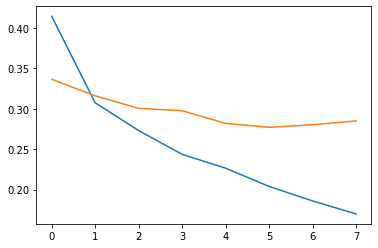

In [33]:
plt.plot(model_one_hist.history['loss'])
plt.plot(model_one_hist.history['val_loss'])

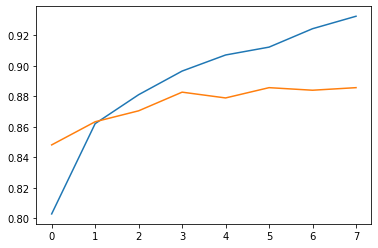

In [34]:
plt.plot(model_one_hist.history['accuracy'])
plt.plot(model_one_hist.history['val_accuracy'])

In [35]:
model_one.evaluate(X_test, test_data.gender)

75/75 [==============================] - 1s 10ms/step - loss: 0.2882 - accuracy: 0.8971


[0.288248747587204, 0.8971332311630249]

In [36]:
preds = [np.round(i, 0) for i in model_one.predict(X_test)]

<AxesSubplot:>

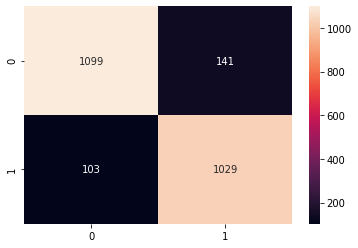

In [37]:
sns.heatmap(confusion_matrix(test_data.gender, preds), annot=True, fmt="d")

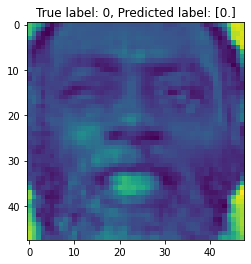

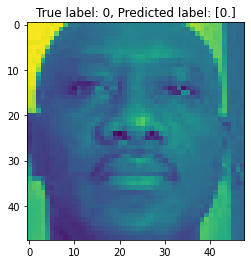

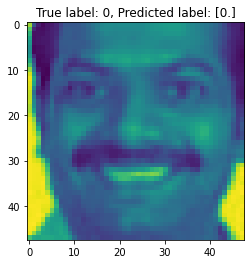

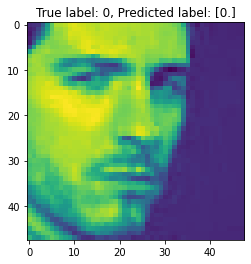

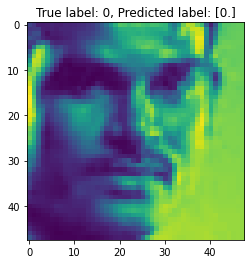

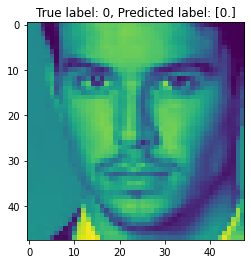

In [40]:
for i in range(6):
    pic = X_test[i] * 255
    plt.title(f"True label: {test_data.gender.iloc[i]}, Predicted label: {preds[i]}")
    plt.imshow(pic)
    plt.show()

### Ethnicity

In [43]:
model_two = Model(inputs=model_one.input, outputs=model_one.layers[-2].output)
model_two = Sequential([
    model_two,
    Dense(len(set(train_data.ethnicity)), activation =  "softmax")
])

In [44]:
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 64)                432880    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 433,205
Trainable params: 433,205
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_two.compile(optimizer=Adam(), loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])

In [47]:
model_two_hist = model_two.fit(X_train, train_data.ethnicity,
                               batch_size=64, epochs=16,
                               validation_data=(X_val, val_data.ethnicity),
                               callbacks=[EarlyStopping(patience=2, restore_best_weights=True, monitor="val_accuracy")])

Epoch 1/16
297/297 [==============================] - 21s 68ms/step - loss: 1.2513 - accuracy: 0.5488 - val_loss: 0.7635 - val_accuracy: 0.7359
Epoch 2/16
297/297 [==============================] - 25s 85ms/step - loss: 0.7506 - accuracy: 0.7372 - val_loss: 0.6990 - val_accuracy: 0.7586
Epoch 3/16
297/297 [==============================] - 18s 59ms/step - loss: 0.6696 - accuracy: 0.7686 - val_loss: 0.6619 - val_accuracy: 0.7688
Epoch 4/16
297/297 [==============================] - 18s 59ms/step - loss: 0.5967 - accuracy: 0.7901 - val_loss: 0.6601 - val_accuracy: 0.7654
Epoch 5/16
297/297 [==============================] - 18s 59ms/step - loss: 0.5310 - accuracy: 0.8149 - val_loss: 0.6520 - val_accuracy: 0.7747
Epoch 6/16
297/297 [==============================] - 18s 60ms/step - loss: 0.4899 - accuracy: 0.8300 - val_loss: 0.6563 - val_accuracy: 0.7848
Epoch 7/16
297/297 [==============================] - 18s 59ms/step - loss: 0.4470 - accuracy: 0.8426 - val_loss: 0.6717 - val_accuracy:

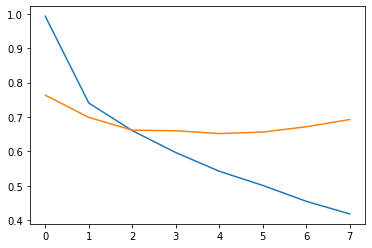

In [48]:
plt.plot(model_two_hist.history['loss'])
plt.plot(model_two_hist.history['val_loss'])

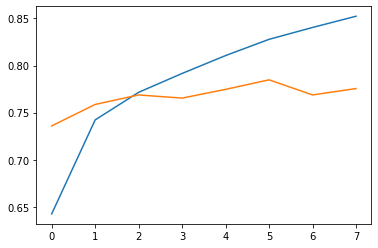

In [49]:
plt.plot(model_two_hist.history['accuracy'])
plt.plot(model_two_hist.history['val_accuracy'])

In [50]:
model_two.evaluate(X_test, test_data.ethnicity)

75/75 [==============================] - 1s 11ms/step - loss: 0.6829 - accuracy: 0.7766


[0.6828595995903015, 0.7765598893165588]

In [52]:
preds = [np.argmax(i) for i in model_two.predict(X_test)]

<AxesSubplot:>

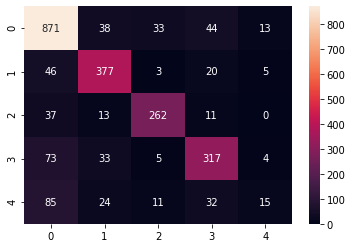

In [54]:
sns.heatmap(confusion_matrix(test_data.ethnicity, preds), annot=True, fmt="d")

For now we saw that the most common class is the most reconised by the model and we have 0 correct prediction of the 4th one. 

### AGE PREDICTION

In [61]:
age_prediciton_model = Sequential([
    Conv2D(16, padding="same", kernel_size=(2, 2), input_shape=((48,48,1))),
    MaxPool2D((2, 2)),
    Conv2D(32, kernel_size=(3, 3), padding="same"),
    Conv2D(32, kernel_size=(3, 3), padding="same"),
    MaxPool2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), padding="valid"),
    Conv2D(64, kernel_size=(3, 3), padding="valid"),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="linear")
])

In [62]:
age_prediciton_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)         

In [63]:
age_prediciton_model.compile(optimizer=Adam(), loss="mean_absolute_error", metrics=['mean_absolute_error'])

In [64]:
age_prediciton_model.fit(X_train, train_data.age,
                               batch_size=120, epochs=12,
                               validation_data=(X_val, val_data.age))

Epoch 1/12
159/159 [==============================] - 32s 200ms/step - loss: 15.8426 - mean_absolute_error: 15.8426 - val_loss: 23.7407 - val_mean_absolute_error: 23.7407
Epoch 2/12
159/159 [==============================] - 32s 200ms/step - loss: 10.5085 - mean_absolute_error: 10.5085 - val_loss: 13.9540 - val_mean_absolute_error: 13.9540
Epoch 3/12
159/159 [==============================] - 32s 200ms/step - loss: 9.8116 - mean_absolute_error: 9.8116 - val_loss: 8.6880 - val_mean_absolute_error: 8.6880
Epoch 4/12
159/159 [==============================] - 32s 200ms/step - loss: 9.0049 - mean_absolute_error: 9.0049 - val_loss: 8.0175 - val_mean_absolute_error: 8.0175
Epoch 5/12
159/159 [==============================] - 31s 197ms/step - loss: 8.4332 - mean_absolute_error: 8.4332 - val_loss: 14.3433 - val_mean_absolute_error: 14.3433
Epoch 6/12
159/159 [==============================] - 32s 200ms/step - loss: 8.2556 - mean_absolute_error: 8.2556 - val_loss: 18.5646 - val_mean_absolute_e

In [65]:
age_prediciton_model.evaluate(X_test, test_data.age)

75/75 [==============================] - 1s 17ms/step - loss: 7.7068 - mean_absolute_error: 7.7068


[7.706766128540039, 7.706766128540039]

In [72]:
preds = age_prediciton_model.predict(X_test)

for i in range(20):
    print(f"True age: {test_data.age.iloc[i]} vs Predicted_age: {int(preds[i])}")

True age: 76 vs Predicted_age: 39
True age: 31 vs Predicted_age: 37
True age: 42 vs Predicted_age: 28
True age: 27 vs Predicted_age: 28
True age: 28 vs Predicted_age: 33
True age: 22 vs Predicted_age: 27
True age: 61 vs Predicted_age: 54
True age: 51 vs Predicted_age: 45
True age: 73 vs Predicted_age: 66
True age: 73 vs Predicted_age: 70
True age: 25 vs Predicted_age: 27
True age: 1 vs Predicted_age: 1
True age: 1 vs Predicted_age: 1
True age: 35 vs Predicted_age: 28
True age: 59 vs Predicted_age: 51
True age: 28 vs Predicted_age: 35
True age: 26 vs Predicted_age: 26
True age: 16 vs Predicted_age: 33
True age: 24 vs Predicted_age: 33
True age: 40 vs Predicted_age: 26


In the end we saw how to create classification and regression models.
Gender model accuracy is nearly 89% and the age prediction with 7 MAE.

The thing is that those pictures were zoomed and most of them missed the hair factor. If we had pics with hair maby our models would be better at predicting (or worse if whe have High bias for women with long hair).

The ethnicity didn't do as well as I would like, but maby some Image augmentation would do a little bit better.
I will continue to edit this notebook with more text... (to be continue.. :) )